# Error Analysis - per zone

In [10]:
## load modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from modeling.functions import get_features, modelling_fc

from sklearn.svm import SVR
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler





In [11]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', \
                    parse_dates= ['TIMESTAMP'],
                    index_col= 'TIMESTAMP' )
                    
data.interpolate(method = 'linear', inplace= True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)

In [12]:
# train-test-split and get features
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]

feature_dict = get_features(data)

In [13]:
data_train.shape

(131280, 46)

In [14]:
models = ['RandomForestRegressor', 'SVR', 'LGBMRegressor']
models_obj = [RandomForestRegressor(), SVR(), LGBMRegressor()]

result_df = pd.DataFrame()

result_dict = {}
for model in models:    
    result_dict[model] = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    result_dict[model]['ZONEID'] = range(1,11) 
    result_df = result_df.append(result_dict[model])

In [17]:
models_dict = {}
prediction_dict = {}
y_test_dict = {} 
X_test_dict = {}

df_results = pd.DataFrame()

for model_obj in models_obj:
    model_name = model_obj.__class__.__name__
    print(model_name)
    df_model = result_dict[model_name]
    
    models_dict[model_name] = {}
    prediction_dict[model_name] = {}
    X_test_dict[model_name] = {}
    y_test_dict[model_name] = {}
    for zone in df_model.ZONEID.unique():
        print(zone)
        fc = df_model[df_model.ZONEID == zone]['FC'].values[0]
        
        data_train_zone = data_train[data_train.ZONEID == zone]
        data_test_zone = data_test[data_test.ZONEID == zone]

        X_train = data_train_zone[feature_dict[fc]]
        X_test = data_test_zone[feature_dict[fc]]
        X_test_dict[model_name][zone] = X_test

        y_train = data_train_zone.TARGETVAR
        y_test = data_test_zone.TARGETVAR
        y_test_dict[model_name][zone] = y_test.values

        best_params = df_model[df_model.ZONEID == zone]['BEST_PARAMS'].values[0]
        model = model_obj.set_params(**ast.literal_eval(best_params))
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = np.array([1 if value >= 1 else 0 if value <= 0 else value for value in y_pred])
        
        tmp_df = deepcopy(data_test_zone)
        tmp_df['MODEL'] = model_name
        tmp_df['PRED'] = y_pred
        tmp_df['RESIDUAL'] = tmp_df.PRED - tmp_df.TARGETVAR

        df_results = df_results.append(tmp_df)
        
        prediction_dict[model_name][zone] = y_pred
        models_dict[model_name][zone] = deepcopy(model)

df_results


RandomForestRegressor
1
2
3
4
5
6
7
8
9
10
SVR
1
2
3
4
5
6
7
8
9
10
LGBMRegressor
1
2
3
4
5
6
7
8
9
10


,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW,MODEL,PRED,RESIDUAL
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-07-01 01:00:00,1,0.625035,5.896003,-1.520128,9.461001,-2.106530,1,7,0,0,...,0,0,0,0,0,1,0,RandomForestRegressor,0.664576,0.039541
2013-07-01 02:00:00,1,0.791185,5.886435,-0.900037,9.019789,-1.276092,2,7,0,0,...,0,0,0,0,1,0,0,RandomForestRegressor,0.576531,-0.214654
2013-07-01 03:00:00,1,0.867400,5.899591,-0.693670,8.685795,-1.147814,3,7,0,0,...,0,0,0,0,1,0,0,RandomForestRegressor,0.551094,-0.316305
2013-07-01 04:00:00,1,0.896814,5.807502,-0.680772,8.629487,-1.117739,4,7,0,0,...,0,0,0,0,1,0,0,RandomForestRegressor,0.550652,-0.346163
2013-07-01 05:00:00,1,0.647214,4.936254,-0.752703,7.652959,-1.130014,5,7,0,0,...,0,0,0,0,1,0,0,RandomForestRegressor,0.477884,-0.169329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,10,0.792143,1.032363,-6.281558,2.041033,-11.220655,20,12,1,0,...,0,0,0,0,0,0,0,LGBMRegressor,0.936122,0.143979
2013-12-31 21:00:00,10,0.792143,1.702361,-6.202448,2.846245,-10.486079,21,12,1,0,...,0,0,0,0,0,0,0,LGBMRegressor,0.933049,0.140906
2013-12-31 22:00:00,10,0.792143,5.086629,-1.261378,7.382256,-3.097656,22,12,1,0,...,0,0,0,0,0,1,0,LGBMRegressor,0.755771,-0.036372


## Define bins

In [18]:
pred_bins = [round(x, 2) for x in np.arange(0, 1.01, 0.05)]
pred_labels = []
for i, bin_ in enumerate(pred_bins):
    if i > len(pred_bins) - 2:
        break
    pred_labels.append(f'{bin_:.2f}-{pred_bins[i + 1]:.2f}')

ws_bins = [round(x, 2) for x in np.arange(0, 25, 2)]
ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')




df_results['PRED_BIN'] = pd.cut(df_results['PRED'], bins = pred_bins, labels=pred_labels)
df_results['WS100_BIN'] = pd.cut(df_results['WS100'], bins = ws_bins, labels=ws_labels)

df_results


,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW,MODEL,PRED,RESIDUAL,PRED_BIN,WS100_BIN
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-07-01 01:00:00,1,0.625035,5.896003,-1.520128,9.461001,-2.106530,1,7,0,0,...,0,0,0,1,0,RandomForestRegressor,0.664576,0.039541,0.65-0.70,8-10
2013-07-01 02:00:00,1,0.791185,5.886435,-0.900037,9.019789,-1.276092,2,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.576531,-0.214654,0.55-0.60,8-10
2013-07-01 03:00:00,1,0.867400,5.899591,-0.693670,8.685795,-1.147814,3,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.551094,-0.316305,0.55-0.60,8-10
2013-07-01 04:00:00,1,0.896814,5.807502,-0.680772,8.629487,-1.117739,4,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.550652,-0.346163,0.55-0.60,8-10
2013-07-01 05:00:00,1,0.647214,4.936254,-0.752703,7.652959,-1.130014,5,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.477884,-0.169329,0.45-0.50,6-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,10,0.792143,1.032363,-6.281558,2.041033,-11.220655,20,12,1,0,...,0,0,0,0,0,LGBMRegressor,0.936122,0.143979,0.90-0.95,10-12
2013-12-31 21:00:00,10,0.792143,1.702361,-6.202448,2.846245,-10.486079,21,12,1,0,...,0,0,0,0,0,LGBMRegressor,0.933049,0.140906,0.90-0.95,10-12
2013-12-31 22:00:00,10,0.792143,5.086629,-1.261378,7.382256,-3.097656,22,12,1,0,...,0,0,0,1,0,LGBMRegressor,0.755771,-0.036372,0.75-0.80,8-10


## Plot residuals

In [23]:
tmp_df.groupby(by = 'WS100_BIN').median()['RESIDUAL'] * (tmp_df.groupby(by = 'WS100_BIN').count()['RESIDUAL'])/len(data_test)

WS100_BIN
0-2      0.000663
2-4      0.002223
4-6      0.004967
6-8      0.003138
8-10    -0.005816
10-12   -0.005187
12-14   -0.002478
14-16   -0.001000
16-18   -0.000150
18-20    0.000127
20-22    0.000044
22-24         NaN
Name: RESIDUAL, dtype: float64

In [28]:
df_results

,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW,MODEL,PRED,RESIDUAL,PRED_BIN,WS100_BIN
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-07-01 01:00:00,1,0.625035,5.896003,-1.520128,9.461001,-2.106530,1,7,0,0,...,0,0,0,1,0,RandomForestRegressor,0.664576,0.039541,0.65-0.70,8-10
2013-07-01 02:00:00,1,0.791185,5.886435,-0.900037,9.019789,-1.276092,2,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.576531,-0.214654,0.55-0.60,8-10
2013-07-01 03:00:00,1,0.867400,5.899591,-0.693670,8.685795,-1.147814,3,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.551094,-0.316305,0.55-0.60,8-10
2013-07-01 04:00:00,1,0.896814,5.807502,-0.680772,8.629487,-1.117739,4,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.550652,-0.346163,0.55-0.60,8-10
2013-07-01 05:00:00,1,0.647214,4.936254,-0.752703,7.652959,-1.130014,5,7,0,0,...,0,0,1,0,0,RandomForestRegressor,0.477884,-0.169329,0.45-0.50,6-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,10,0.792143,1.032363,-6.281558,2.041033,-11.220655,20,12,1,0,...,0,0,0,0,0,LGBMRegressor,0.936122,0.143979,0.90-0.95,10-12
2013-12-31 21:00:00,10,0.792143,1.702361,-6.202448,2.846245,-10.486079,21,12,1,0,...,0,0,0,0,0,LGBMRegressor,0.933049,0.140906,0.90-0.95,10-12
2013-12-31 22:00:00,10,0.792143,5.086629,-1.261378,7.382256,-3.097656,22,12,1,0,...,0,0,0,1,0,LGBMRegressor,0.755771,-0.036372,0.75-0.80,8-10


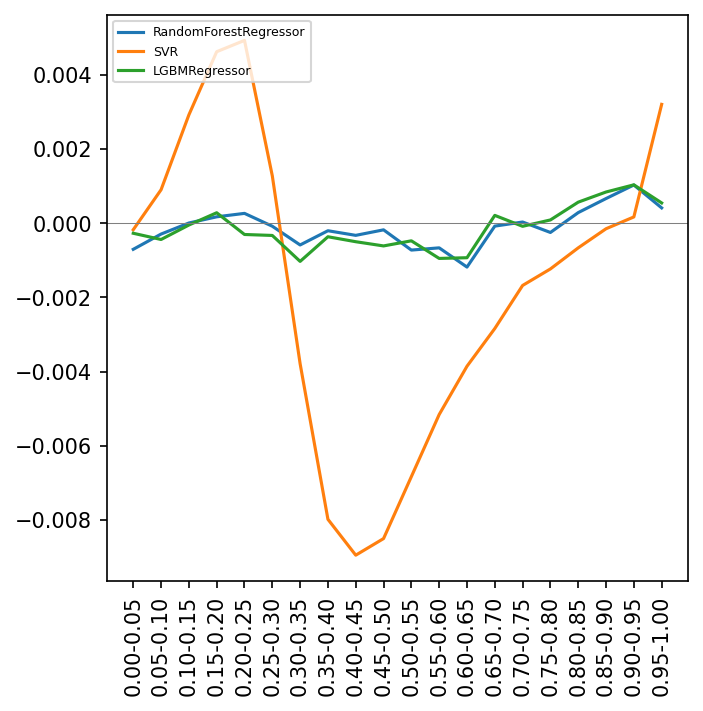

In [29]:
fig, axs = plt.subplots(figsize = (5,5), dpi = 150)

for model in models:
    tmp_df = df_results[df_results.MODEL == model]
    means = tmp_df.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] * (tmp_df.groupby(by = 'PRED_BIN').count()['RESIDUAL'])/len(data_test)
    axs.plot(means)
axs.axhline(color = 'gray', linewidth = 0.5)
axs.legend(models, loc = 'upper left', fontsize = 6)
plt.xticks(rotation = 90)
plt.show()

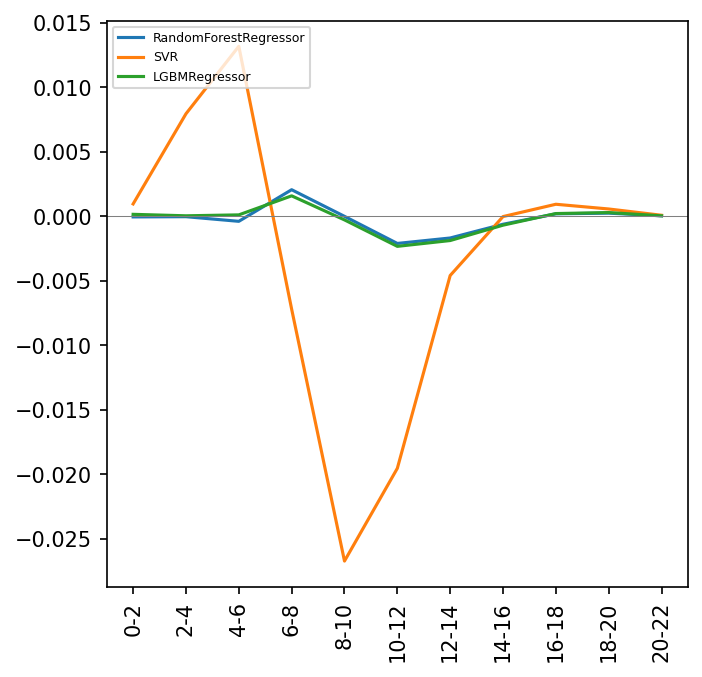

In [27]:
fig, axs = plt.subplots(figsize = (5,5), dpi = 150)

for model in models:
    tmp_df = df_results[df_results.MODEL == model]
    means = tmp_df.groupby(by = 'WS100_BIN').mean()['RESIDUAL'] * (tmp_df.groupby(by = 'WS100_BIN').count()['RESIDUAL'])/len(data_test)
    axs.plot(means)
axs.axhline(color = 'gray', linewidth = 0.5)
axs.legend(models, loc = 'upper left', fontsize = 6)
plt.xticks(rotation = 90)
plt.show()

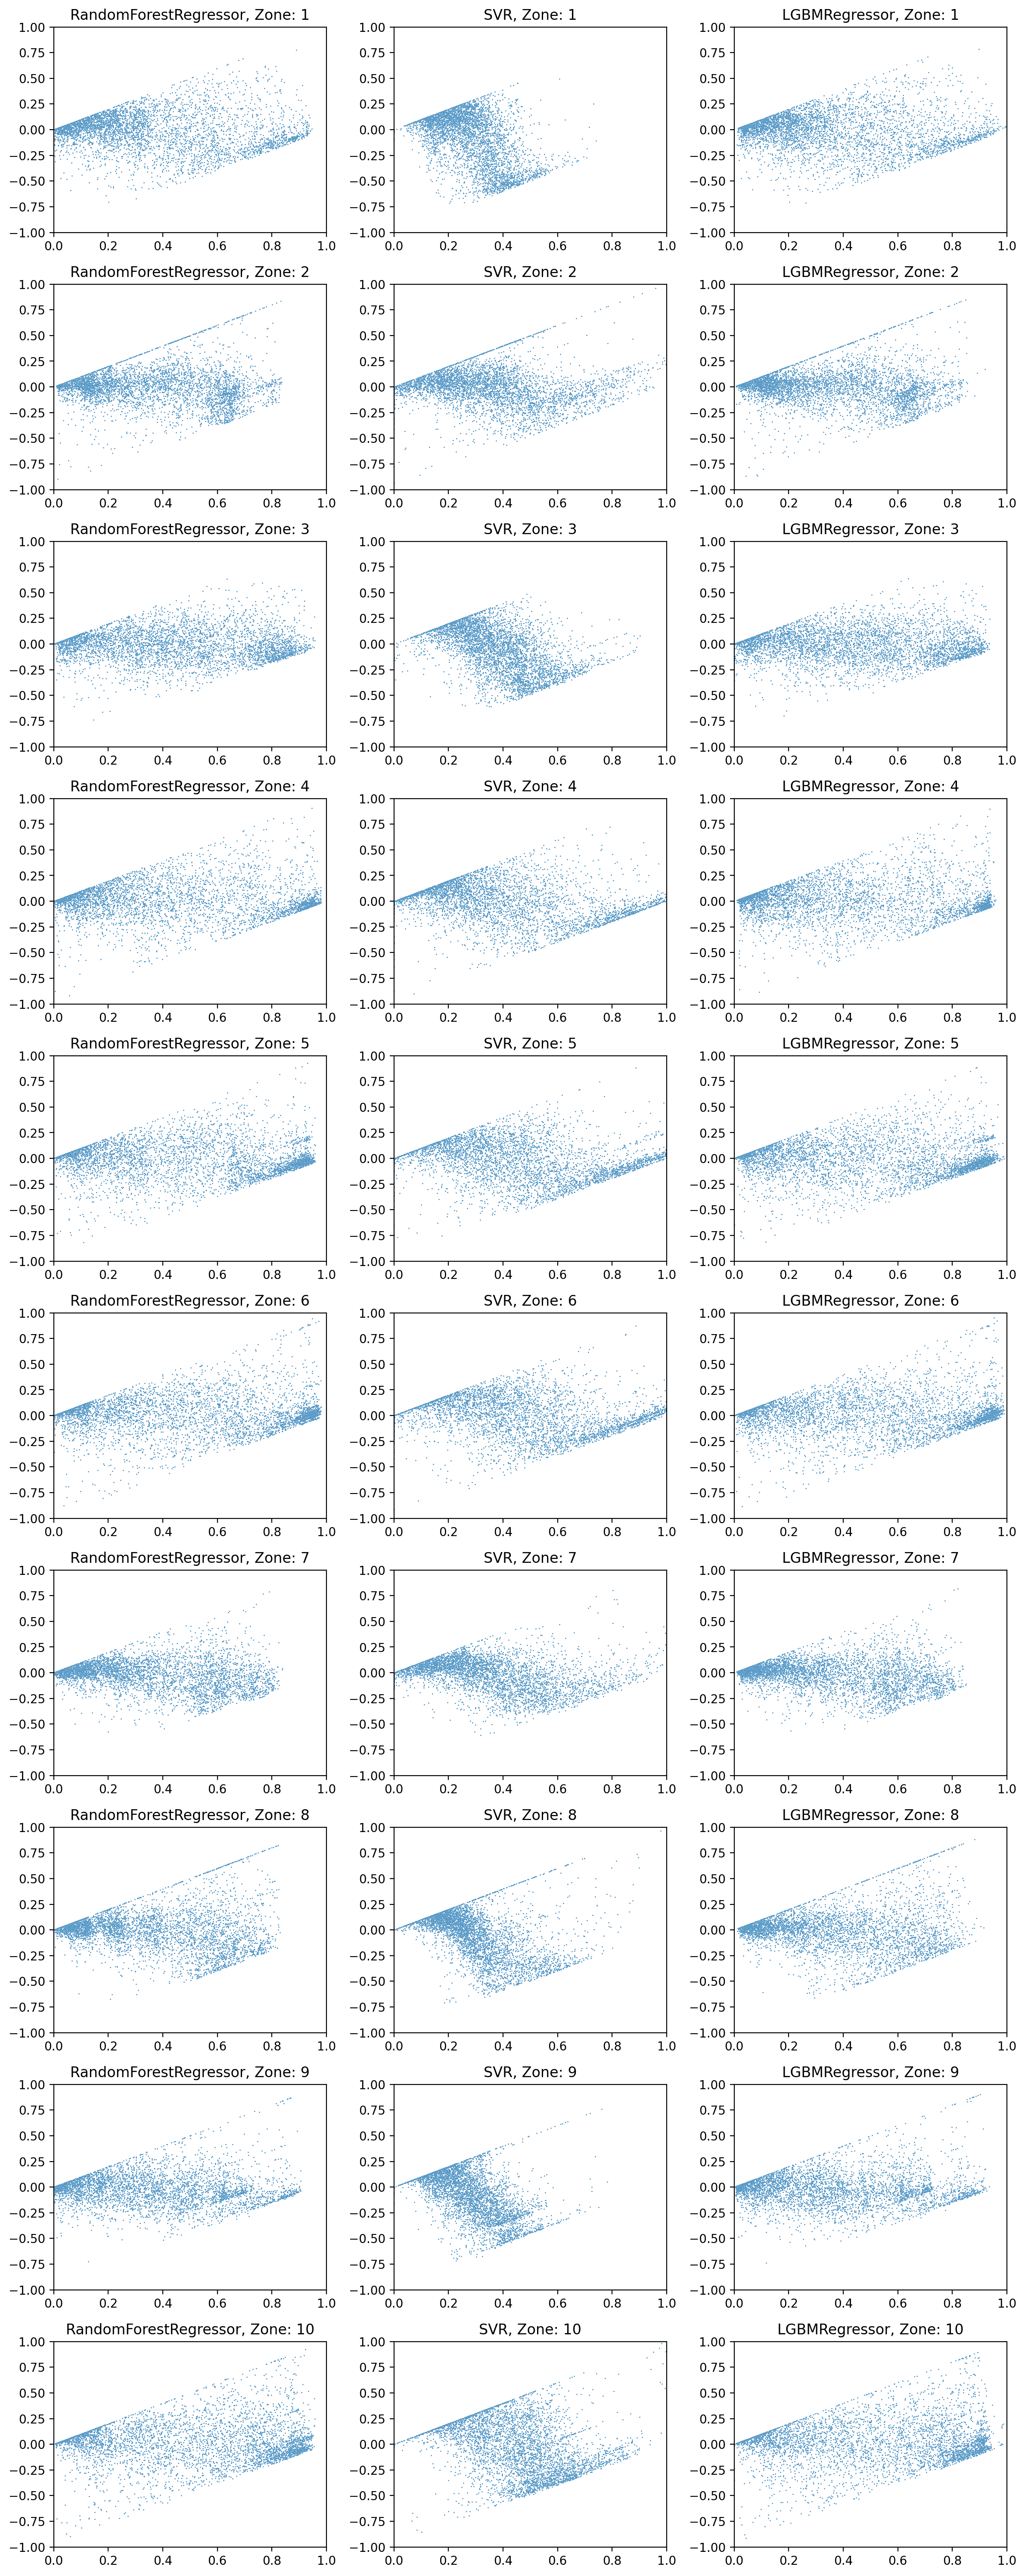

In [31]:
model = 'SVR'
zone = 1

residuals_dict = {}

fig, axs = plt.subplots(10,3,figsize = (12,30), dpi = 200)
#axs = axs.ravel()

for col, model in enumerate(models):
    residuals_dict[model] = {}
    
    for zone in range(1,11):
        residuals_dict[model][zone] = prediction_dict[model][zone] - y_test_dict[model][zone]
        y = residuals_dict[model][zone]
        x = prediction_dict[model][zone]
        sns.scatterplot(x = x, y = y, s = 1, ax = axs[zone - 1, col])
        axs[zone - 1, col].set_title(f'{model}, Zone: {zone}')
        axs[zone - 1, col].set_xlim([0,1])
        axs[zone - 1, col].set_ylim([-1,1])
        fig.tight_layout()    


#print(max(prediction_dict[model][zone]), min(prediction_dict[model][zone]), np.mean(residuals_dict[model][zone]))
    

# Plot of bias by prediction bin

In [33]:
data_test.head()

,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-07-01 01:00:00,1,0.625035,5.896003,-1.520128,9.461001,-2.106530,1,7,0,0,...,0,0,0,0,0,0,0,0,1,0
2013-07-01 02:00:00,1,0.791185,5.886435,-0.900037,9.019789,-1.276092,2,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 03:00:00,1,0.867400,5.899591,-0.693670,8.685795,-1.147814,3,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 04:00:00,1,0.896814,5.807502,-0.680772,8.629487,-1.117739,4,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 05:00:00,1,0.647214,4.936254,-0.752703,7.652959,-1.130014,5,7,0,0,...,0,0,0,0,0,0,0,1,0,0


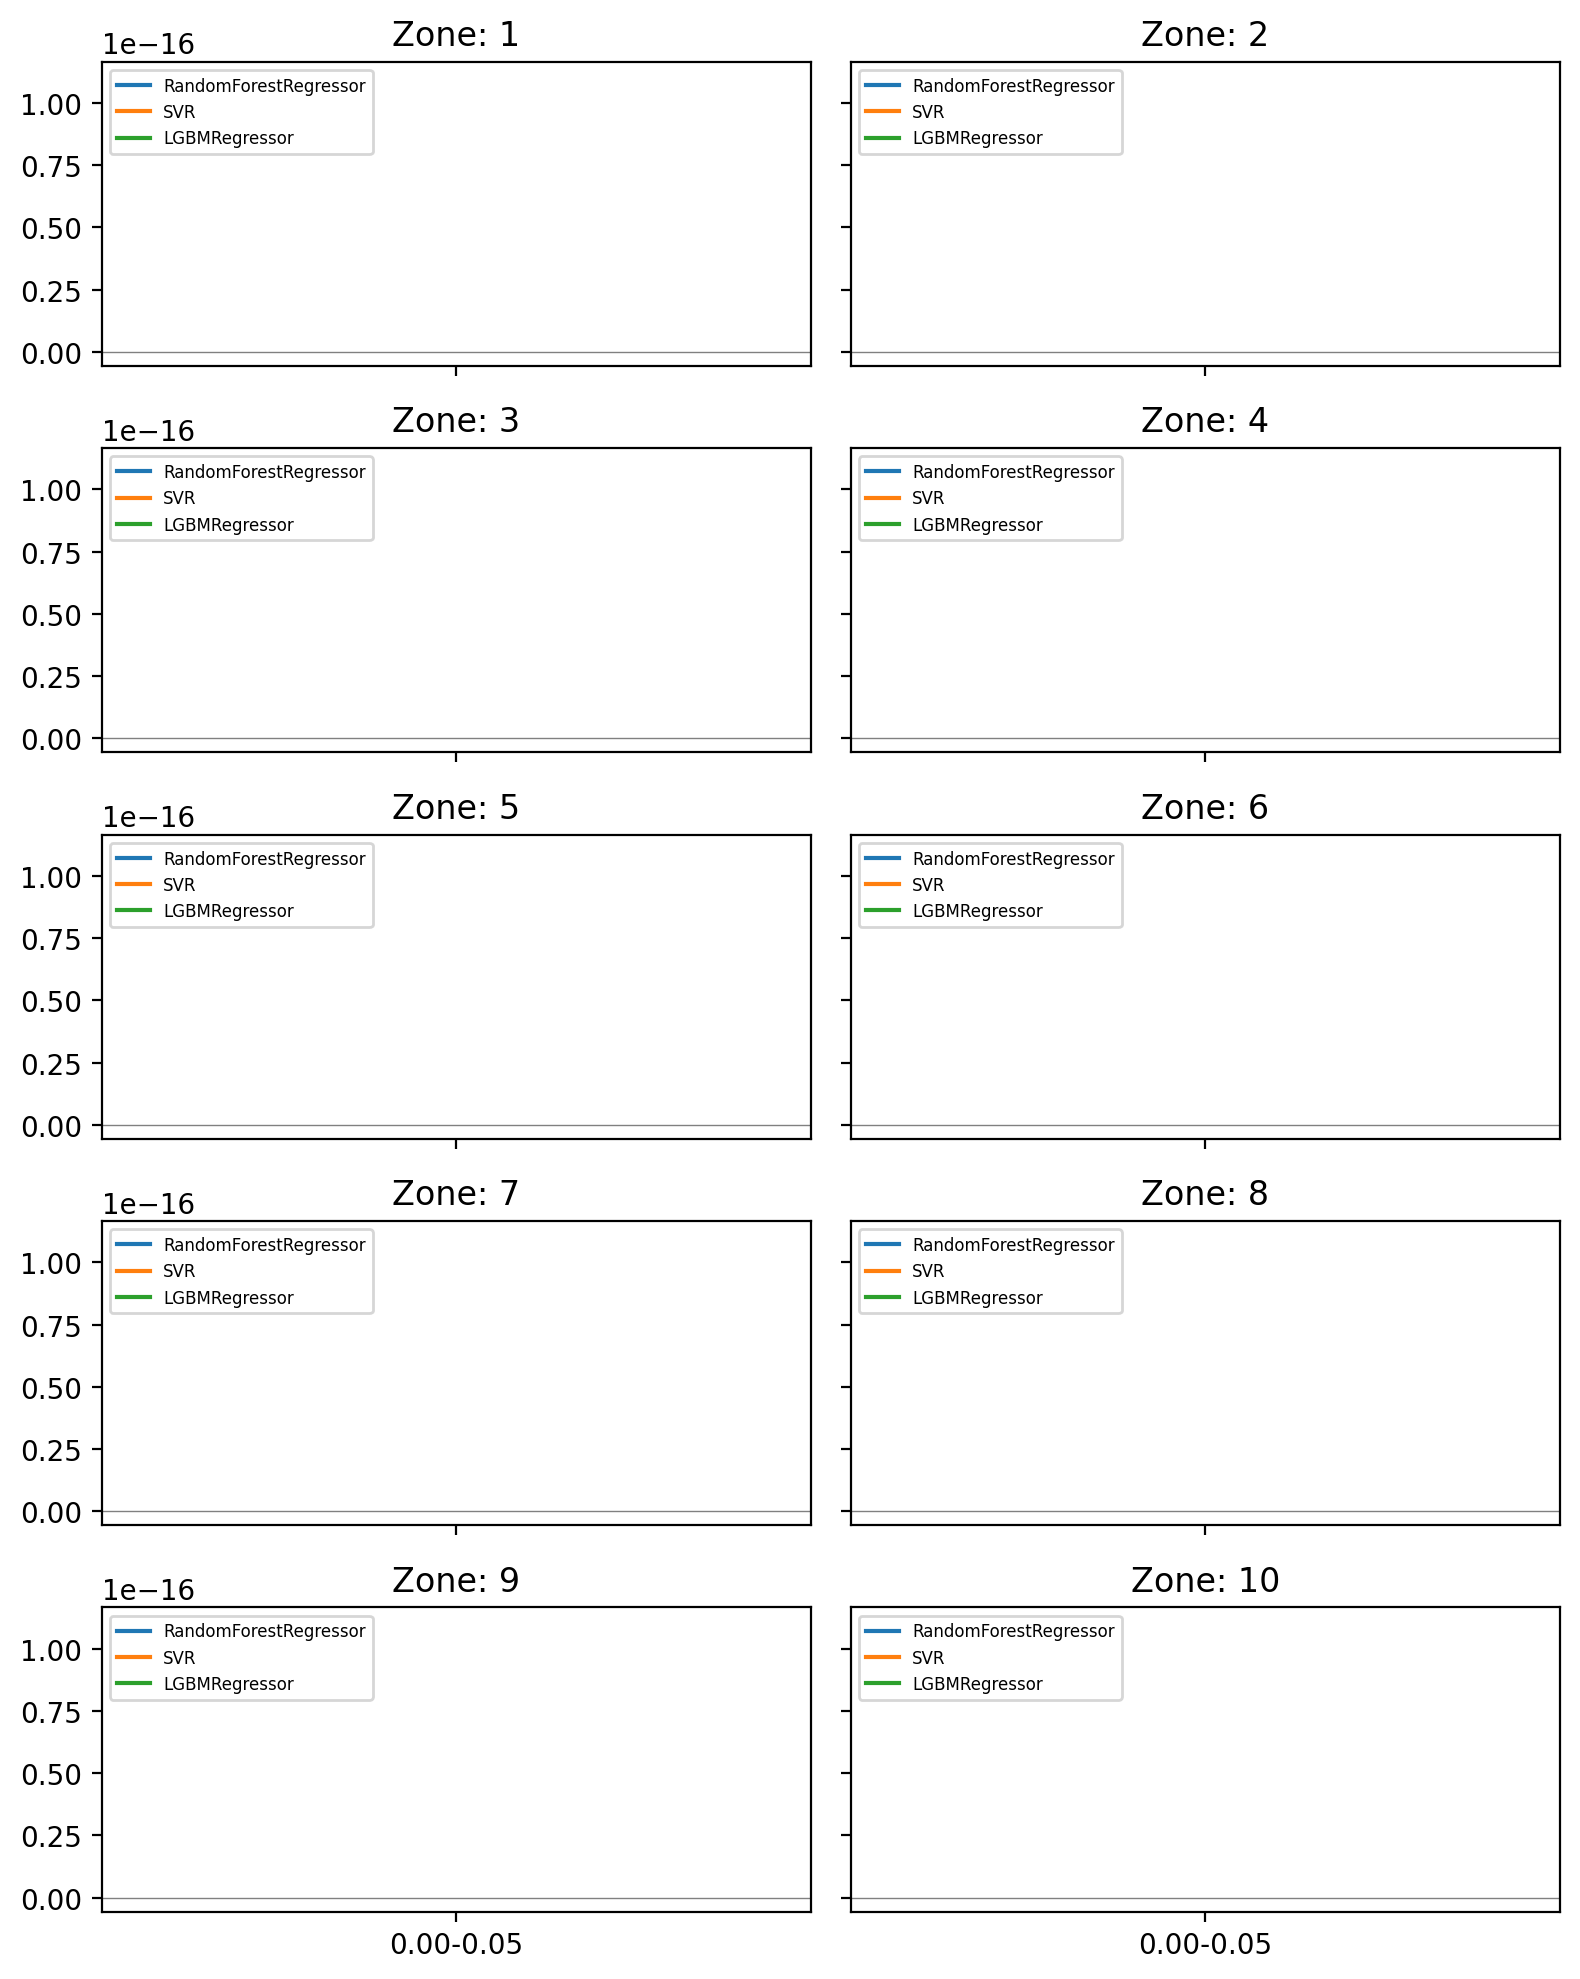

In [36]:
pred_bins = [round(x, 2) for x in np.arange(0, 1.01, 0.05)]

pred_labels = []
for i, bin_ in enumerate(pred_bins):
    if i > len(pred_bins) - 2:
        break
    pred_labels.append(f'{bin_:.2f}-{pred_bins[i + 1]:.2f}')

pred_bin_dict = {}
for model in models:
    pred_bin_dict[model] = {}
    for zone in range(1,11):
        tmp_df = pd.DataFrame(prediction_dict[model][zone], columns = ['PRED'])
        pred_bin_dict[model][zone] = pd.cut(tmp_df['PRED'], bins = pred_bins, labels=pred_labels)

fig, axs = plt.subplots(5,2,figsize = (8,10), dpi = 200, sharey= True, sharex= True)
axs = axs.ravel()


for zone in range(1,11):
    for model in models:
        y = residuals_dict[model][zone]
        x = pred_bin_dict[model][zone]
        tmp_df = pd.DataFrame({'PRED_BIN': x, 'RESIDUAL': y})
        means = tmp_df.groupby(by = 'PRED_BIN').mean() * (tmp_df.groupby(by = 'PRED_BIN').count()['RESIDUAL'])/len(y)
        axs[zone - 1].plot(means)
    axs[zone - 1].axhline(color = 'gray', linewidth = 0.5)
    axs[zone - 1].legend(models, loc = 'upper left', fontsize = 6)
    axs[zone - 1].set_title(f'Zone: {zone}')
        # axs[zone - 1, col].set_xlim([0,1])
        # axs[zone - 1, col].set_ylim([-1,1])
    fig.tight_layout()

# Plot of bias by prediction bin including variance

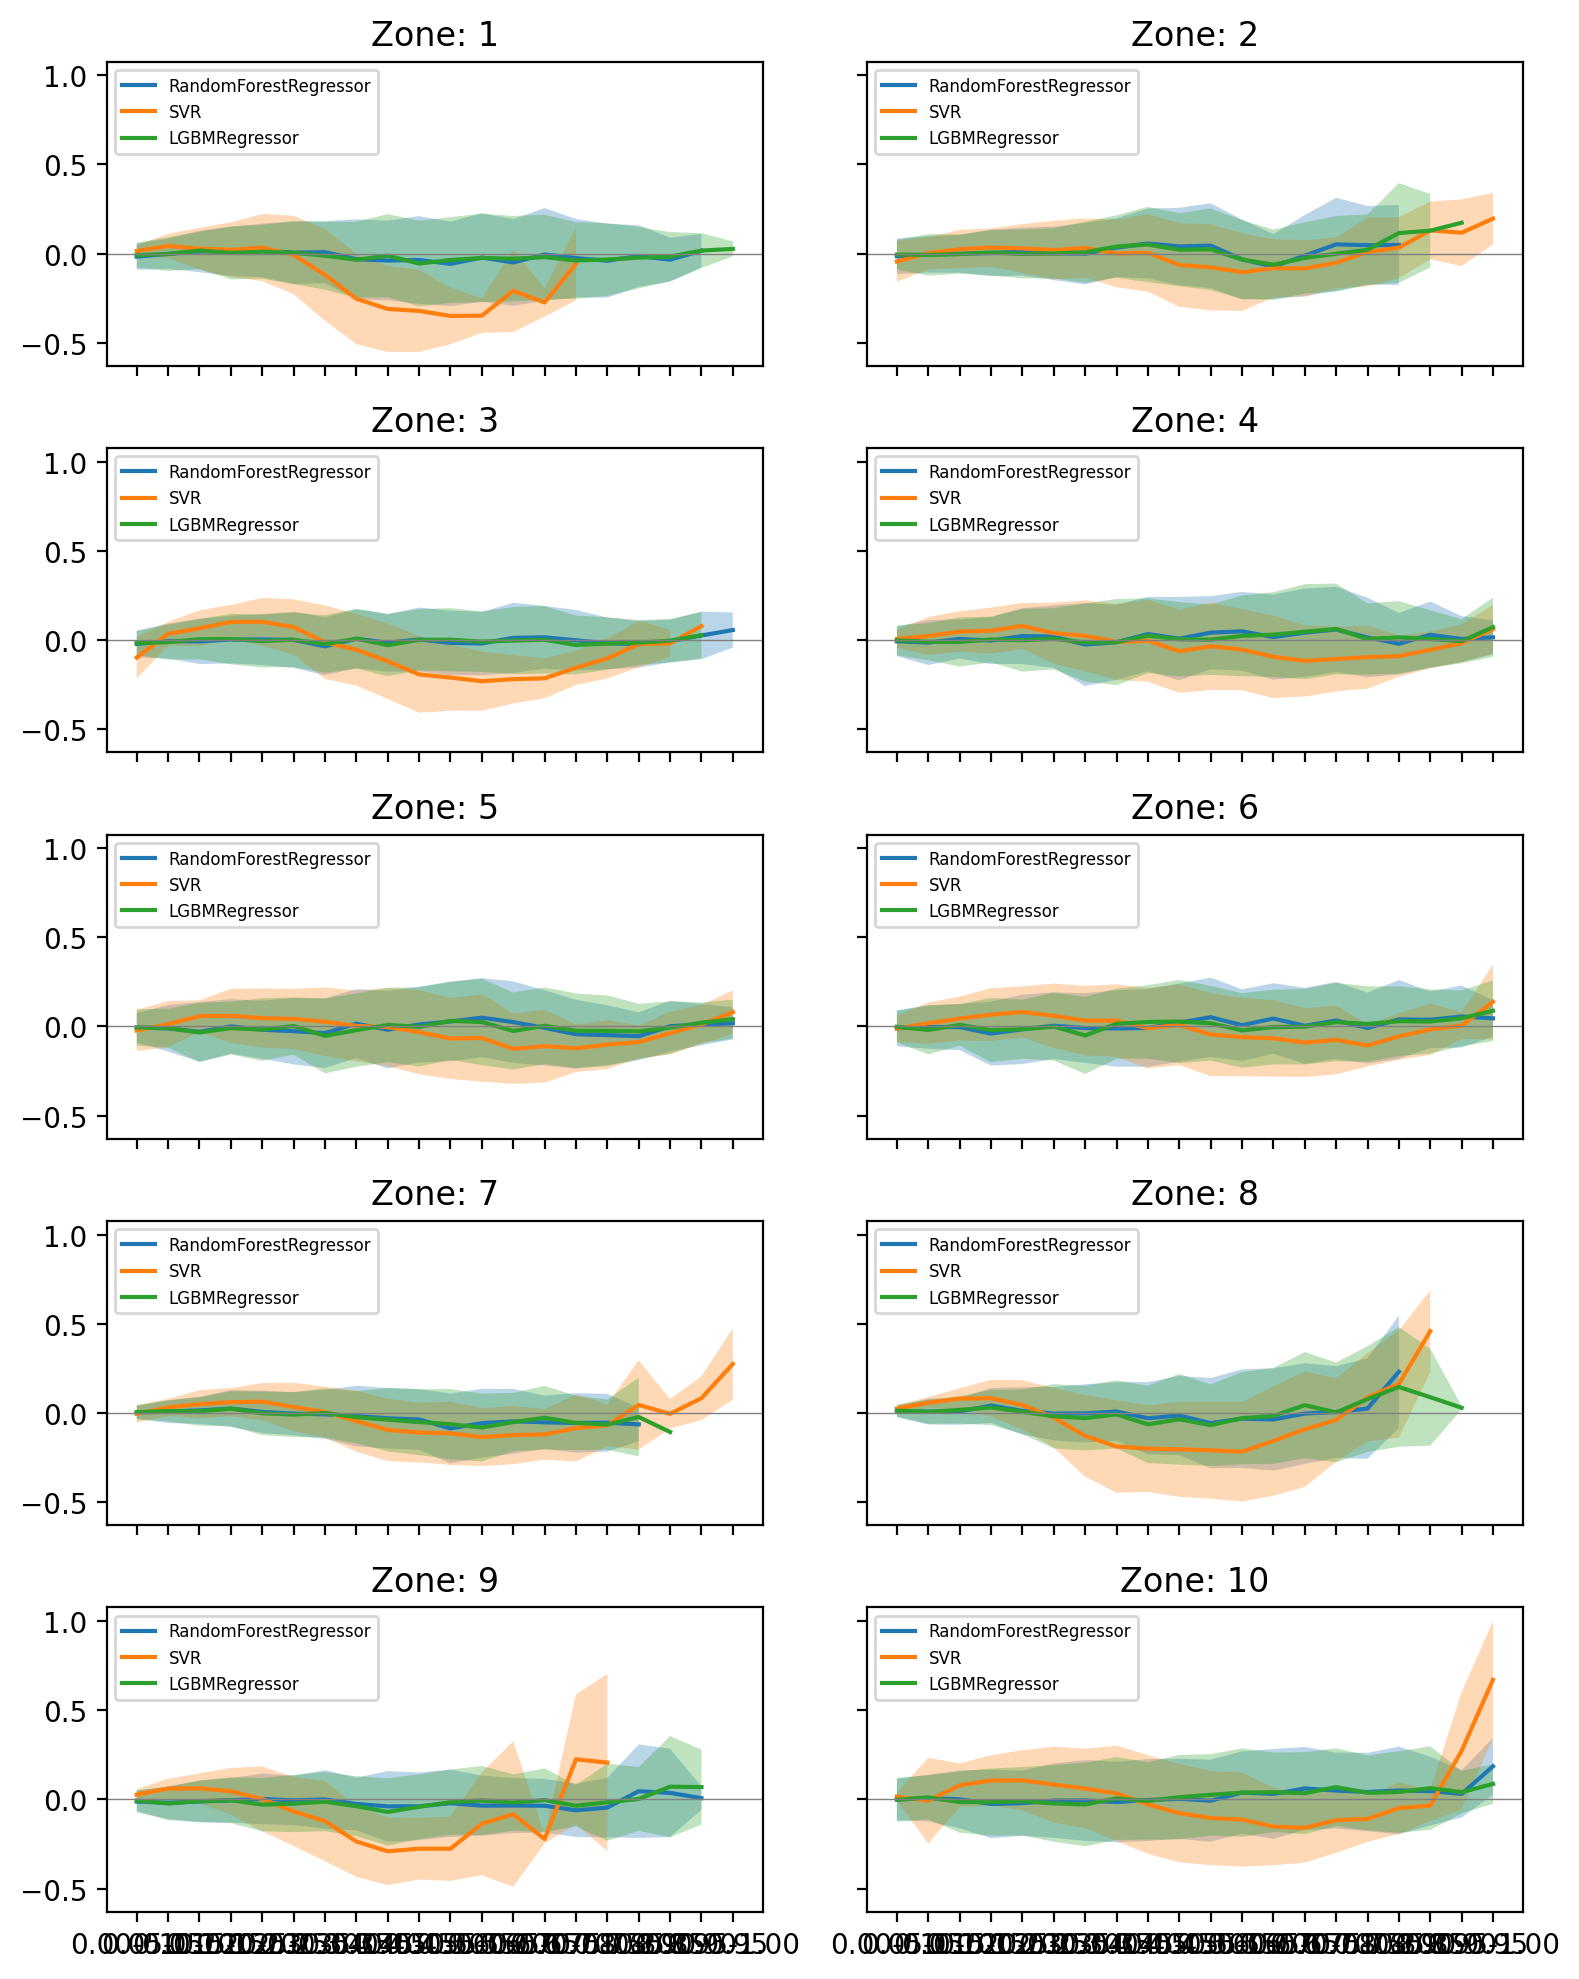

In [116]:
fig, axs = plt.subplots(5,2,figsize = (8,10), dpi = 200, sharey= True, sharex= True)
axs = axs.ravel()

#color_list = ['black','red','blue']
for zone in range(1,11):
    for idx, model in enumerate(models):
        y = residuals_dict[model][zone]
        x = pred_bin_dict[model][zone]
        tmp_df = pd.DataFrame({'PRED_BIN': x, 'RESIDUAL': y})
        means = tmp_df.groupby(by = 'PRED_BIN').mean()
        stds = tmp_df.groupby(by = 'PRED_BIN').std()
        axs[zone - 1].fill_between(x = means.index, y1 = (means - stds).values.ravel(), y2 = (means + stds).values.ravel(), alpha = 0.3)#, color = color_list[idx])
        axs[zone - 1].plot(means)#, color = color_list[idx])
        
    axs[zone - 1].axhline(color = 'gray', linewidth = 0.5)
    axs[zone - 1].legend(models, loc = 'upper left', fontsize = 6)
    axs[zone - 1].set_title(f'Zone: {zone}')
        # axs[zone - 1, col].set_xlim([0,1])
        # axs[zone - 1, col].set_ylim([-1,1])
    fig.tight_layout()

# Plot of bias by windspeed bins

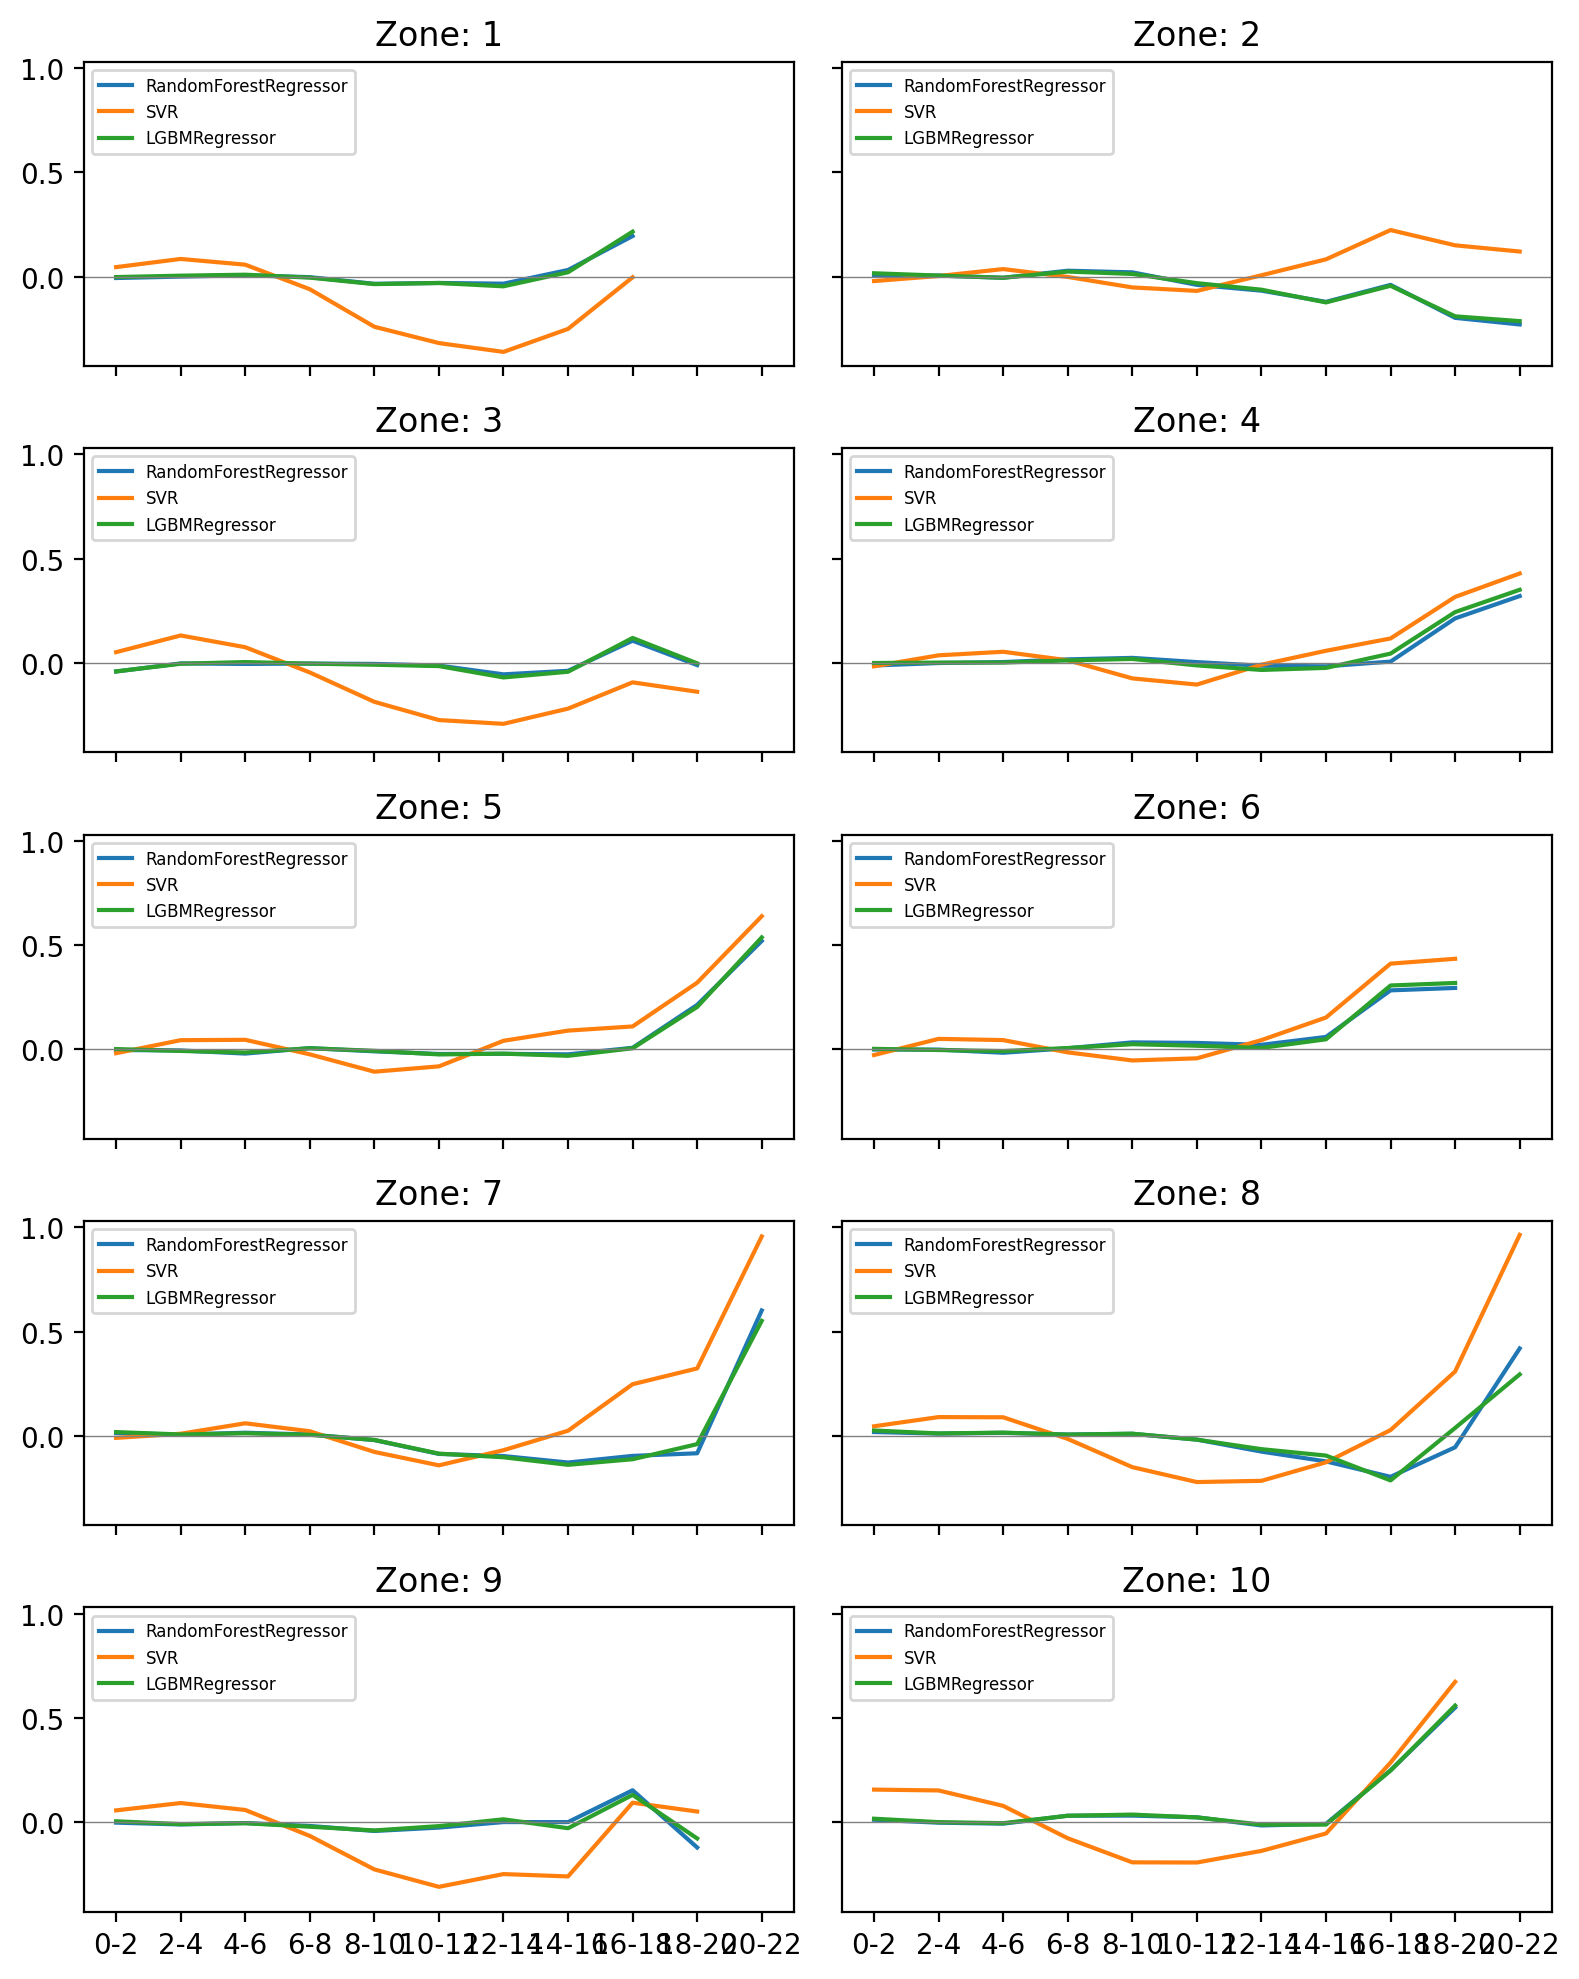

In [122]:
ws_bins = [round(x, 2) for x in np.arange(0, 26, 2, dtype = int)]

ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')

ws_bin_dict = {}
for model in models:
    ws_bin_dict[model] = {}
    for zone in range(1,11):
        tmp_df = pd.DataFrame(X_test_dict[model][zone]['WS100'], columns = ['WS100'])
        ws_bin_dict[model][zone] = pd.cut(tmp_df['WS100'], bins = ws_bins, labels=ws_labels)


fig, axs = plt.subplots(5,2,figsize = (8,10), dpi = 200, sharey= True, sharex= True)
axs = axs.ravel()


for zone in range(1,11):
    for model in models:
        y = residuals_dict[model][zone]
        x = ws_bin_dict[model][zone]
        tmp_df = pd.DataFrame({'WS100_BIN': x, 'RESIDUAL': y})
        means = tmp_df.groupby(by = 'WS100_BIN').mean()
        axs[zone - 1].plot(means)
    axs[zone - 1].axhline(color = 'gray', linewidth = 0.5)
    axs[zone - 1].legend(models, loc = 'upper left', fontsize = 6)
    axs[zone - 1].set_title(f'Zone: {zone}')
        # axs[zone - 1, col].set_xlim([0,1])
        # axs[zone - 1, col].set_ylim([-1,1])
    fig.tight_layout()

In [ ]:
ws_bins = [round(x, 2) for x in np.arange(0, 26, 2, dtype = int)]

ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')

ws_bin_dict = {}
for model in models:
    ws_bin_dict[model] = {}
    for zone in range(1,11):
        tmp_df = pd.DataFrame(X_test_dict[model][zone]['WS100'], columns = ['WS100'])
        ws_bin_dict[model][zone] = pd.cut(tmp_df['WS100'], bins = ws_bins, labels=ws_labels)


fig, axs = plt.subplots(5,2,figsize = (8,10), dpi = 200, sharey= True, sharex= True)
axs = axs.ravel()


for zone in range(1,11):
    for model in models:
        y = residuals_dict[model][zone]
        x = ws_bin_dict[model][zone]
        tmp_df = pd.DataFrame({'WS100_BIN': x, 'RESIDUAL': y})
        means = tmp_df.groupby(by = 'WS100_BIN').mean()
        axs[zone - 1].plot(means)
    axs[zone - 1].axhline(color = 'gray', linewidth = 0.5)
    axs[zone - 1].legend(models, loc = 'upper left', fontsize = 6)
    axs[zone - 1].set_title(f'Zone: {zone}')
        # axs[zone - 1, col].set_xlim([0,1])
        # axs[zone - 1, col].set_ylim([-1,1])
    fig.tight_layout()